# Mineral Prediction Mapping with Machine Learning

### With the continued demand for mineral deposit discoveries and the advancements in AI and machine learning, the connection between the geosciences and the data science disciplines is gaining more time in the spotlight. Over the past year I've seen a huge increase in studies, courses and conferences that marry the two fields in a very exciting manner. Along with this comes skepticism that combining these fields is taking the science away from exploration geology. In this following example I explain how to create a mineral prediction map using machine learning, feeding a skeptics belief by birthing a somewhat 'black box' classification model. My main intention however, is to create a step by step guide to create basic classification maps for interested geologists. Using open source program QGIS and programming language Python, I'll hopefully shed some light on how machine learning can become an essential tool when used correctly. 

<img src="Images/BLOG.png" />

The data used in this notebook is all open source and comes from a crowdsourcing competition run by Oz Minerals in early 2019 (a bit late to the party I know). The intention of the competition was for people to define drill targets using a large geoscience dataset provided by the company. I selected a small study area from this data suite that contains 89 drillholes with EOH depths between 258-1207m and is covered by regional geophysics data, including radiometrics, magnetics and gravity surveys. Geological data (lithological and structural) is also utilised from this data suite. The Random Forest model created classifies areas of interest, which I defined as zones where drillhole targets had incercepted gold values of 0.8g/t or more. 

The data used to create the model contains the pixels from a 25m buffer zone around drill collars. The pixel values for these areas were assigned the integers 1 - a barren area, and 2 - an area of interest, depending on the gold values of the drill core assays. This particular case study contains very 'black box' thinking, with the intention of explaining how to create spatial machine learning models and emphasise the importance of understanding your modelled data, rather than providing a sound mineral prediction map. 

<img src="Images/Min Pred Map.png" />

### INGREDIENTS

###### QGIS (3.8)

###### Geospatial Data
- Geophysics rasters
- Lithology/Structure Vectors
- Drillhole Data

###### Python (3.6) and Packages
- Numpy
- Sklearn
- Matplotlib
- Pandas
- Rasterio

The ingredients list include all the things used in this notebook. Initially we'll cover data preperation in QGIS then dive into the processing and machine learning of tiff images using python and associated packages. Finally we'll look at creating images from our new predicted data, assign them the associated co-ordinate reference system and export them to tiff files. Lets get cookin'.

<img src="Images/BB.png" />

### DATA PREPERATION IN QGIS
1. Open and assess geospatial data
2. Select a study area
3. Clip rasters and vectors to this polygon
4. Define areas of interest
5. Create buffer around areas of interest
5. Create buffer around faults that define distance from fault
6. Rasterize Geology
7. Export as tiff files ensuring all rasters now have same pixel dimensions

<img src="Images/steps123.png" />

After downloading all the open source data provided by Oz Minerals, the first thing I did was load the data into QGIS. QGIS is a free geogrpahic information systems application that is perfect for viewing and editing geospatial data. After having a gander, I selected an area that agreed with my two prerequisites: 1. has enough data to create a significant model and 2. not too much data that would crash my poor deteroiating macbook. Once I had my area selected, I clipped all the geophysics and geology data I wanted (radiometrics, gravity, magnetics, geology, fault and drillhole data) to this area.

<img src="Images/steps4567.png" />

There was a large amount of holes drilled in this area, so to filter them out a bit I selected the 89 holes that were drilled deeper than 250m. From this, I seperated the drillholes into 2 groups, ones that had <0.8g/t gold and ones that had 0.8g/t gold or more, then created a 50m buffer around these areas and exported them from point-vector data to a raster file. The pixel values of this raster deem whether the pixel is an area of interest, not an area of interest or if it was an unknown area. The next step was to create a buffer zone around the fault structures and rasterize that image. Each pixel represents metre values between 10-10000m with 10m intervals. For the geology, I assigned each different unit an integer value and then rasterized the polygon layer so that the each pixel values represent a lithology, eg 1 = Undifferentiated Granite, 2 = Gabbro and so on. After all the images had been prepared in QGIS I exported them as tiff files ensuring that the pixel values were the same for each image, 840x840.

<img src="Images/Images.png" />

With all 6 image files ready to play around with, lets get started with the python processing. First we want to import a few python packages and read the images into our notebook.

### PYTHON PROCESSING

In [1]:
#Importing the initial few python packages as their usual aliases
import pandas as pd
import numpy as np
from skimage import io

#Loading up georeferenced tiff images from file using skimage
grav = io.imread('/Users/jackmaughan/Images/Gravity.tif')
mag = io.imread('/Users/jackmaughan/Images/Magnetics.tif')
rad = io.imread('/Users/jackmaughan/Images/Radiometrics.tif')
geo = io.imread('/Users/jackmaughan/Images/Geology.tif')
fault = io.imread('/Users/jackmaughan/Images/Distance to Fault.tif')
AOI = io.imread('/Users/jackmaughan/Images/Areas of Interest.tif')

#Checking the image datatypes 
print(type(rad))

<class 'numpy.ndarray'>


Here we have loaded all 6 images as numpy arrays using the python package 'skimage'. Numpy array is the input data format which is required by the machine learning python package 'sklearn' so this is a good start. However, when importing images as numpy arrays it is important to make sure that they have the same dimensions (or shape). To check this we do as follows:

In [2]:
#Analysing the shape of each numpy array,
print('Radiometrics shape is',rad.shape)
print('Magnetics shape is',mag.shape)
print('Gravity shape is',grav.shape)
print('Geology shape is',geo.shape)
print('Distance to Fault shape is',fault.shape)
print('Area of Interest shape is',AOI.shape)

Radiometrics shape is (840, 840, 4)
Magnetics shape is (840, 840, 4)
Gravity shape is (840, 840, 3)
Geology shape is (840, 840)
Distance to Fault shape is (840, 840)
Area of Interest shape is (840, 840)


We see that our geology, fault distance and area of interest images are 2 dimensional arrays (or matrices) of shape 840x840. This represents the pixel size of the image. The other 3 images however, were imported as 3 dimensional arrays. They still have the 840x840 matrix, but they also have a 3rd dimension represented by the number 3 for gravity and 4 for radiometrics and magnetics. This means that there is 3 or 4 lots of 840x840 matrices in this numpy array. For images this usually relates to the Red, Green, Blue (3) and sometimes Alpha (4) bands of the image (4 different layers of the same image, overlain to create the full image). 

<img src="Images/Bands.png" />

To be able to create our model these numpy arrays must all be of the same shape. If we have a look at the radiometrics image:

In [3]:
#Analysing radiometrics array
print(rad)

[[[255 102 255 255]
  [255 102 255 255]
  [255 102 255 255]
  ...
  [158  52  90 255]
  [158  52  90 255]
  [158  52  90 255]]

 [[255 102 255 255]
  [255 102 255 255]
  [255 102 255 255]
  ...
  [158  52  90 255]
  [158  52  90 255]
  [158  52  90 255]]

 [[255 102 255 255]
  [255 102 255 255]
  [255 102 255 255]
  ...
  [158  52  90 255]
  [158  52  90 255]
  [158  52  90 255]]

 ...

 [[198  65 255 255]
  [198  65 255 255]
  [198  65 255 255]
  ...
  [107 182 183 255]
  [107 182 183 255]
  [107 182 183 255]]

 [[198  65 255 255]
  [198  65 255 255]
  [198  65 255 255]
  ...
  [107 182 183 255]
  [107 182 183 255]
  [107 182 183 255]]

 [[198  65 255 255]
  [198  65 255 255]
  [198  65 255 255]
  ...
  [107 182 183 255]
  [107 182 183 255]
  [107 182 183 255]]]


We can see the 4 dimensions of each pixel, where the first pixel is represented by values [255, 102, 255, 255]. This means that the red value = 255, the green value = 102, the blue value = 255 and the alpha value = 255 for the pixel. The alpha value represents the opaqeness of an image. In this case it is equal to 255 which means there is no image transperancy and because it is constant for the whole image we can ignore this band. To be able to have these images as 2D arrays we need to reimport them into the notebook, this time importing them as greyscale images using skimage's conversion formulas. Skimage scales the pixel values to values between 0-1 when imported, but this won't matter as we will scale all features before creating a model anyway.

<img src="Images/RGBA-Grey.png" />

In [4]:
#Reimporting the images as greyscale, making them two dimensional
grav = io.imread('/Users/jackmaughan/Images/Gravity.tif', as_gray=True)
mag = io.imread('/Users/jackmaughan/Images/Magnetics.tif', as_gray=True)
rad = io.imread('/Users/jackmaughan/Images/Radiometrics.tif', as_gray=True)

#Analysing the new array shapes
print('The new Gravity shape is',grav.shape)
print('The new Magnetics shape is',mag.shape)
print('The new Radiometrics shape is',rad.shape)

The new Gravity shape is (840, 840)
The new Magnetics shape is (840, 840)
The new Radiometrics shape is (840, 840)


Looking at the array shapes now, we can see that they are 2 dimensional, 840x840 matrices, just the way we wanted. For Sklearn to be able to read our numpy arrays however, they must be one dimensional. To do this we use numpys 'flatten' module. this just means we are taking each row of the matrix and lining them up behind each other like a giant conga line of pixels.

In [5]:
#Flattening the arrays to become a single 1D numpy array or vector list of pixel values
rad = rad.flatten()
mag = mag.flatten()
grav = grav.flatten()
geo = geo.flatten()
fault = fault.flatten()
AOI = AOI.flatten()

#Checking the shape or array length lines up for all arrays
print(rad.shape)
print(mag.shape)
print(grav.shape)
print(geo.shape)
print(fault.shape)
print(AOI.shape)

(705600,)
(705600,)
(705600,)
(705600,)
(705600,)
(705600,)


<img src="Images/Grey.png" />

The image pixel values have now been converted into a single dimensional array of 705,600 values, which when lined up and transposed can be represented as a data table. With the help of python package 'Pandas', this is our next step. 

In [6]:
#Creating a pandas dataframe from all the arrays. T is used to transpose the dataframe
df = pd.DataFrame(data=[rad, mag, grav, geo, fault, AOI]).T

#Assigning the column names to each feature
df.columns=['rad', 'mag', 'grav', 'geo', 'fault', 'AOI']

#Checking to see if it worked
print(df.head(5))

        rad       mag      grav  geo   fault  AOI
0  0.570760  0.410940  0.206239  7.0  9780.0  0.0
1  0.570760  0.403662  0.274180  7.0  9780.0  0.0
2  0.570760  0.392745  0.422416  7.0  9770.0  0.0
3  0.570760  0.359996  0.490357  7.0  9770.0  0.0
4  0.556733  0.330885  0.481092  7.0  9770.0  0.0


Here we can see the first 5 lines of the dataframe (or data table). The Rad, Mag and Grav columns (or features) are represented by numeric pixel values between 0-1, the Geolgy column is represented by integer values corresponding to geological units, the fault column is represented by numeric values corresponding to metres from faults and the Areas of Interest column is represented by 3 values; 0.0 = unknown, 1.0 = not an area of interest and 2.0 = an area of interest. In this case we're happy to have the rad, mag, grav and fault features to be numeric (or float) but we want the AOI and geology columns to be categorical. To do this we change the data type to be 'str' (string).

In [7]:
#Assigning the correct data types to each feature
df.rad=df['rad'].astype(float)
df.mag=df['mag'].astype(float)
df.grav=df['grav'].astype(float)
df.fault=df['fault'].astype(float)
df.geo=df['geo'].astype(str)
df.AOI=df['AOI'].astype(str)

print(df.dtypes)

rad      float64
mag      float64
grav     float64
geo       object
fault    float64
AOI       object
dtype: object


Next we want to start creating our model. For this we only want the areas where we know the gold values (where AOI=1.0 or AOI=2.0), so we need to drop all the areas of unknown values, creating a subset dataframe.

In [8]:
#Creating a subset dataframe where the area of interest value is known
df_model=df[df['AOI']!=('0.0')]

#Checking our new data
print(df_model.describe())

               rad          mag         grav        fault
count  1100.000000  1100.000000  1100.000000  1100.000000
mean      0.642128     0.267719     0.297213   413.609091
std       0.254206     0.186817     0.200634   721.883324
min       0.020000     0.027992     0.031102    10.000000
25%       0.430215     0.124167     0.120916   110.000000
50%       0.694310     0.201831     0.227782   220.000000
75%       0.894696     0.346559     0.429828   400.000000
max       1.000000     0.887873     0.898789  4160.000000


Now we have a new data frame containing our known AOI values consiting of 1100 rows (instances). We can start to build a model from this new dataframe. First we need to split our target variable (Areas of interest) from the rest of our features, and convert them back into numpy arrays.

<img src="Images/stinkypete.png" />

### MODEL CREATION

In [9]:
#Creating our target variable and feature variables from the dataframe in preperation for machine learning
y = np.array(df_model.pop('AOI').values)
X = np.array(df_model)

For machine learning we will use the python package Sci-kit Learn. To do this we must split our X and y arrays into training and testing data. Using the train_test_split module for sklearn we will use a 75/25 training/test split and then scale our data using a minmax scaler.

In [10]:
#Importing the train/test and scaling modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Splitting the data 75/25% into training and test data and then scaling the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

#Scaling our features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

For no particular reason, I've chosen to use the Random Forest algorithm for the machine learning prediction. Random Forest is an ensemble classification method that uses a multitude of decision trees to predict a class. For further infomation regarding the maths and processing behind RF I highly reccomend googling it. Like most machine learning algorithms, random forest has many changeable parameters that can be fine tuned to increase the models accuracy. It can be difficult to determine the best parameters manually, but thankfully the sklearn module GridSearchCV can filter through all possible parameters we set and determine what works best. This has been set up in the next step.

<img src="Images/GridSearch.png" />

In [11]:
#Importing the random forest classifier and grid search module
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Creating our inital test classifier
RF = RandomForestClassifier()

#Selecting our algorithm variables that will be tested on our dataset and running them through a grid search
grid_param_RF = { 'n_estimators': [100, 300, 500, 800, 1000], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]}
gd_sr_RF = GridSearchCV(estimator=RF, param_grid=grid_param_RF, scoring='accuracy',cv=10, n_jobs=-1)
gd_sr_RF.fit(X_train, y_train)

#Assigning a variable to the best paramaters and the classification accuracy
best_parameters_RF = gd_sr_RF.best_params_
best_result_RF = gd_sr_RF.best_score_

print(best_parameters_RF)
print(best_result_RF)

{'bootstrap': False, 'criterion': 'gini', 'n_estimators': 100}
0.9866666666666667


According to our grid search, our best paramteres are 'bootstrap'= False, 'criterion'= entropy and 'n_estimators'= 300, which result in a whopping 98.9% classification accuracy!!(!!!!). Red lights flashing already, this is very well classified and extremely likely due to an overfitting model. However, the accuracy of our model is not the main focus of this example, so we'll run with this super model and continue progressing. Now that we know the parameters we want to use, we can rename our model and fit it to the data.

In [12]:
#Creating a new model with the desired parameters
model = RandomForestClassifier(bootstrap=False, criterion= 'entropy', n_estimators= 100)

#Fitting the model to the training data
model.fit(X_train, y_train)

#Printing all the model parameters
print(model)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


With our new model, we can run the classification on every single pixel in our study area. To do this we remove the AOI column from the inital data frame and run a scaler on our features (must use the same scaled input values that the model learnt from).

In [13]:
#Splitting the inital dataframe 
y_new = np.array(df.pop('AOI').values)
X_new = np.array(df)

#Scaling it to match the model input
X_new = scaler.fit_transform(X_new)

Here we can create numpy arrays of our classification values, and the probability of each class being correctly classified. Remember that if the value is classified as 1 it is not an area of interest, and if it is classified as a 2 it is an area of interest.

In [14]:
#Creating numpy arrays of the classification (prediction) data and the probablity that each value either satisfies 
#AOI=1 or AOI=2
y_pred = model.predict(X_new)
y_prob = model.predict_proba(X_new)

print(y_pred.shape, y_prob.shape)

(705600,) (705600, 2)


We can see that the prediction array is 1 dimensional and that the probability array is 2 dimensional. This makes sense as the values in the prediction array would either be 1 or 2. The probability array however, has the probability value of the pixel being classified as a 1 and the possibilty value of the pixel being classified as a 2. We can split this 2 dimensional array into 2 seperate 1 dimensional arrays. As the probability of a pixel being classified as a 1 has the inverse probability of being classified as a 2, we only really need to pay attention to one of the probability splits.

<img src="Images/fruit ninja.png" />

In [15]:
#Splitting the y_prob array into two seperate 1 dimensional arrays
y_prob_split = np.split(y_prob, 2, axis=1)

y_prob_1 = y_prob_split[0]
y_prob_2 = y_prob_split[1]

print(y_prob_1.shape)

(705600, 1)


Now we have the probability arrays back into a safe and workable 1 dimensional conga line, we can reshape them back into 840x840 arrays. To do this we use numpys 'reshape' function. As y_pred was classified as str we can now change the datatype back to float, which is needed to convert to tif files.

In [16]:
#Reshaping the 1d arrays to be representable as an image
y_pred = y_pred.reshape(840, 840).astype(float)
y_prob_1 = y_prob_1.reshape(840, 840)
y_prob_2 = y_prob_2.reshape(840, 840)

Here are 3 new, 2-dimensional numpy arrays that we have created using machine learning. Our next step is to export the images and visualize them. There are a few different techniques to converting numpy arrays to image files, but as we are working with geospatial data, it's important that we can georeference our images to the same co-ordinate reference system (CRS) as our study area. We can do this by referencing the metadata of one of our inital features through a python package called rasterio. First we use rasterio to open one of our images and have a look at the data. We will use the Geology raster as a reference.

### GEOREFERENCING

In [17]:
#Importing rasterio 
import rasterio as rio

#Accessing the metadata of the existing 'Geology' image
with rio.open('/Users/jackmaughan/Images/Geology.tif') as src:
    study_area_ras = src.read()
    study_area_meta = src.profile

print(study_area_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 840, 'height': 840, 'count': 1, 'crs': CRS.from_dict(init='epsg:28353'), 'transform': Affine(25.0, 0.0, 529000.0,
       0.0, -25.0, 6733000.0), 'tiled': False, 'interleave': 'band'}


<img src="Images/JackSparrow.png" />

Here we can see all the metadata associated with the geology raster, but our main interest is the transform and the CRS

In [18]:
#Viewing the transform and crs
study_area_transform = study_area_meta["transform"]
study_area_crs = study_area_meta["crs"]

print(study_area_transform)
print(study_area_crs)

| 25.00, 0.00, 529000.00|
| 0.00,-25.00, 6733000.00|
| 0.00, 0.00, 1.00|
EPSG:28353


The study area transform gives us the upper left reference point of the image. This is a 25x25 unit pixel beginning at an easting of 529000 and northing of 673300 in the co-ordinate reference system of EPSG:28353. This is the metadata we want out new images to have, but we must make a slight change first. We want the 'count' (or number of bands) of our reference to equal 1 and the 'dtype' must be the same as our input data.  In this case our reference image already has count=1 as our geology raster only has 1 band, but it's good practice to change it every time. 

In [19]:
#Ensuring the count value is 1 (1 band of pixel data) and assigning the data as float to be compatible with the 
#new data
study_area_meta['count'] = 1
study_area_meta['dtype'] = "float64"

print(study_area_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0, 'width': 840, 'height': 840, 'count': 1, 'crs': CRS.from_dict(init='epsg:28353'), 'transform': Affine(25.0, 0.0, 529000.0,
       0.0, -25.0, 6733000.0), 'tiled': False, 'interleave': 'band'}


Now we've got the metadata all ready to go, we can set it to our numpy arrays and export them to file as tif images. These can be bought back into QGIS now and placed in our study area.

In [20]:
#Saving each georeferenced tiff in a designated file location 

with rio.open('/Users/jackmaughan/Images/y_pred.tif', 'w', **study_area_meta) as dst1:
    dst1.write(y_pred, 1)

with rio.open('/Users/jackmaughan/Images/y_prob_1.tif', 'w', **study_area_meta) as dst2:
    dst2.write(y_prob_1, 1)
    
with rio.open('/Users/jackmaughan/Images/y_prob_2.tif', 'w', **study_area_meta) as dst3:
    dst3.write(y_prob_2, 1)

The files are now saved, georeferenced and ready to go. As we have the data in our workflow already we can have a quick look at how the probability image turned out using MatPlotLib. 

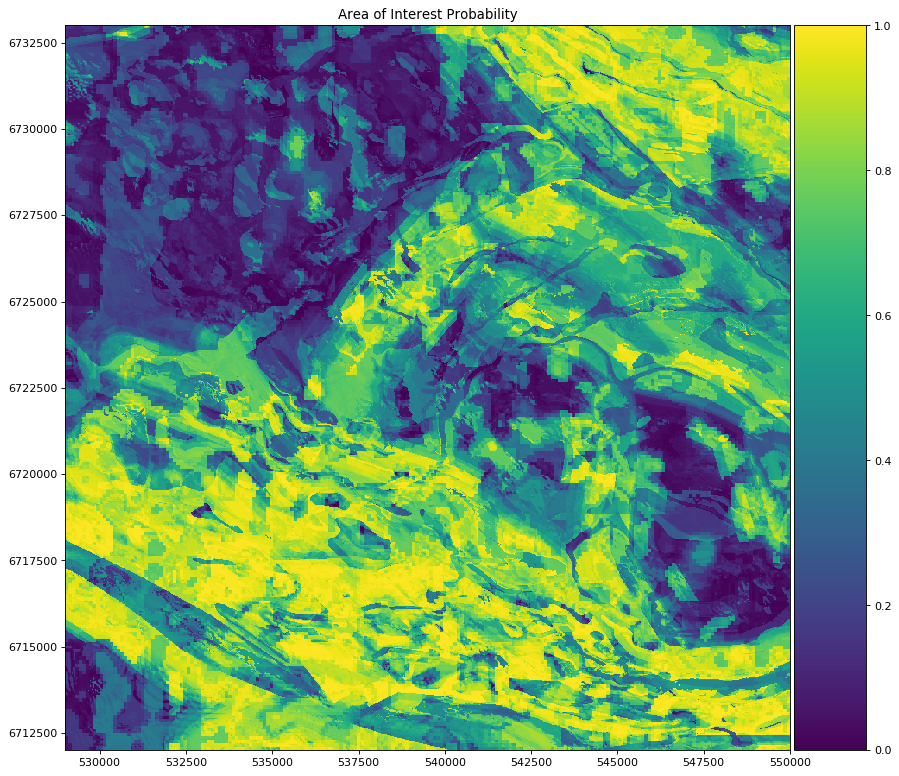

In [22]:
#Importing required packages
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *

#Setting the image size
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

#Setting the eastings and northings boundary
bounds = [529000, 550000, 6712000, 6733000]

#Loading the image data and setting extents
plt.title('Area of Interest Probability')
ax = plt.gca()
im = ax.imshow(y_prob_2, interpolation='nearest', extent=bounds)

#Plotting colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

#Visualising the image
plt.show()

Bang, there we have it. A machine learnt prediction/probability map that classifies whether areas contain >0.8g/t gold. Foolproof. Almost. Kind of. Not at all. Some components of the map make sense, like the highest probability areas tend to follow the mapped faults, and the lowest probability areas do not show much magnetic differentiation. There are some issues however, that definitely need to be taken into consideration. 

### ISSUES TO CONSIDER

##### Input Data Issues
1. The first issue that stands out is that the model was trained on pixels that are located on drill collars. The pixel values however, came from assay data with depths >250m and did not take into account the declination and azimuth of the drillholes. Where the pixels are assigned do not give a true representation of the gold values at this point. For this kind of work flow, it is important to only use data that is depth matched to all the features, or consider constructing a 3D model.


2. You don't have to be geophysics guru to see that the Gravity and Magnetic images were preprocessed and the resulting tif files contained a 'hillshading' component for a visual effect. This affects our model as the pixels will have different values even though the geophysical response may be the same. To avoid this it is best to work with and understand raw geophysical data.


3. The training data is highly concentrated in the southern part of the study area which causes some bias towards that area. The best solution to the sparsity of data is to collect more data.

#### Geology Issues
1. Airborne Radoimetrics?? how well does that correlate with gold values?? at assays of >250m depth???? This is why it is important to understand what data is going into your model, radiometrics is effectively useless in this example. There is a component of machine learning (which I have explained in a previous blog) called feature ranking, which determines how important a feature is in model creation. Understanding how each feature correlates with the target variable is worth considering for future models.


2. Mineral deposits are more often than not structurally controlled, which is why the 'Distance from Fault' feature was incorporated into the model. One thing that was not included in the thought process of this feature is what each fault represents. Are there different faulting events? What is the structure-mineralisation relationship? Did some of this faulting occur post mineralisation? This is an example of how understanding all aspects of geology in your study area will greatly affect what can and should go into your model.

#### Model Issues
1. The Random Forest model returned a classification accuracy of 98.9%. If we think about the issues already mentioned, the accuracy realistically should not be that high. This is most likely due to overfitting, where the model has learnt all the little variations/data noise in our training/test data and accomodated for it. A way of removing overfitting is by altering model parameters or trying a multitude of different machine learning algorithms and finding out what one works best. Some studies I've read in the same field use Support Vector Machine (SVM) or Convolutional Neural Network (CNN) methods, stating that these are the best approaches to this kind of problem.


2. In the geology layer of the study area there are 22 mapped units. All drill collar locations combined only experienced 11 of these 22 units. This means that from our geology feature, we trained our model with only half of the geology in the study area. When the model was run on the entire dataset it had to classify areas with 11 lithological unts it had never seen before. If you give a kid 5 pictures of cats, 5 pictures of dogs and then ask them to draw a fish you're gonna have a fun time, but an inaccurate looking fish. Having a new lithology the model hasn't seen before is like handing the model unlabelled data. The best way to avoid this is to train the model based on data that covers the whole study area, or venture into the realm of semi-supervised classification.

<img src="Images/Thanos.png" />

### CONCLUSION

Understanding how to apply machine learning techniques to mineral exploration is a fun and exciting process, but also requires an understanding of the issues associated with black box model creation. This work flow is no doubt littered with issues I have not mentioned but I hope the ones I have mentioned emphasise the importance of understanding input data and model properties. Having a balance of geoscience and data science knowledge to make the most out your model is essential. Geology has never been an exact science, but getting as close to exact as possible is crucial for the future of mineral deposit discovery.